In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from lhotse import LilcomFilesWriter

from lhotse.recipes.ami import download_ami, prepare_ami
from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.cut import CutSet
from lhotse.dataset.sampling import SingleCutSampler
from lhotse.dataset.speech_recognition import K2SpeechRecognitionDataset
from lhotse.dataset.vad import VadDataset

# Settings for paths

In [7]:
root_dir = Path('data')
output_dir = root_dir

# Download the dataset

In [5]:
download_ami(root_dir, mic = "ihm")

# Prepare audio and supervision manifests

In [8]:
ami_manifests = prepare_ami(root_dir, output_dir)

# Extract features

In [9]:
example = ami_manifests['dev']

example['cuts'] = CutSet.from_manifests(
    recordings=example['recordings'],
    supervisions=example['supervisions']
).compute_and_store_features(
    extractor=Fbank(),
    storage_path=f'{output_dir}/feats_example',
    storage_type=LilcomFilesWriter,
)

Extracting and storing features: 100%|██████████| 104/104 [07:33<00:00,  4.36s/it]


# Make PyTorch Dataset for ASR task

In [ ]:
asr_dataset = K2SpeechRecognitionDataset(example['cuts'].trim_to_supervisions())

# Illustation of an example

In [ ]:
sampler = SingleCutSampler(asr_dataset.cuts, shuffle=False, max_cuts=4)
cut_ids = next(iter(sampler))

In [ ]:
sample = asr_dataset[cut_ids]
print(sample['supervisions']['text'][0])

WELCOME EVERYBODY


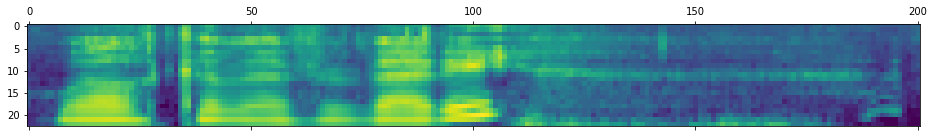

In [ ]:
plt.matshow(sample['inputs'][0].transpose(0, 1).flip(0))

# Make PyTorch Dataset for VAD task

In [15]:
#vad_dataset = VadDataset(example['cuts'].cut_into_windows(10.0, keep_excessive_supervisions=True))
vad_dataset = VadDataset()

# Illustation of an example

In [18]:
sampler = SingleCutSampler(example['cuts'], shuffle=False, max_cuts=4)
cut_ids = next(iter(sampler))

In [19]:
sample = vad_dataset[cut_ids]

label_height = 10
vad_label = torch.stack([sample['is_voice'] for i in range(label_height)]).reshape(label_height, 1000)
plt.matshow(vad_label)
plt.matshow(sample['inputs'][0].transpose(0, 1).flip(0))

RuntimeError: shape '[10, 1000]' is invalid for input of size 4559080